In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [4]:
# Load the dataset
df = pd.read_csv(r"/content/fdc_small_78634_20cols.csv")
df.head()


/tmp/ipython-input-188031600.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/content/fdc_small_78634_20cols.csv")


,fdc_id,brand_owner,description,ingredients,gtin_upc,serving_size,serving_size_unit,branded_food_category,modified_date,available_date,"Calcium, Ca-MG","Carbohydrate, by difference-G",Cholesterol-MG,"Copper, Cu-MG",Energy-KCAL,"Fatty acids, total monounsaturated-G","Fatty acids, total polyunsaturated-G","Fatty acids, total saturated-G","Fatty acids, total trans-G","Fiber, soluble-G"
0,1512818,"C & C Cola Co., Inc.",COLA,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CA...",41699128118,355.0,ml,Soda,2018-08-10,2021-03-19,NaN,10.99,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
1,1612821,Hannaford Bros. Co.,HOMESTYLE CHICKEN & RICE SOUP,"CHICKEN BROTH, CARROTS, ROASTED WHITE MEAT CHI...",41268143597,245.0,g,Canned Soup,2019-09-10,2021-03-19,8.0,6.53,4.0,NaN,41.0,0.0,0.0,0.00,0.00,NaN
2,2597262,Aron Streit Inc.,"EGG & ONION MATZOS, EGG; ONION","UNBLEACHED WHEAT FLOUR, WATER, ONION POWDER, E...",70227500058,28.0,GRM,Crackers & Biscotti,2023-06-23,2023-07-13,50.0,82.14,54.0,NaN,393.0,NaN,NaN,0.00,0.00,NaN
3,1634603,Sabra Dipping Company LLC,BABAGANOUSH,"EGGPLANT, MAYONNAISE (COTTONSEED OIL, EGG YOLK...",40822343206,28.0,g,Dips & Salsa,2020-12-01,2021-03-19,0.0,7.14,18.0,NaN,250.0,NaN,NaN,3.57,0.00,NaN
4,574083,Food Town Stores Inc.,CORNED BEEF HASH,"BEEF, REHYDRATED POTATOES, WATER, CONTAINS 2% ...",035826105820,236.0,g,Chili & Stew,2018-04-10,2019-04-01,11.0,9.32,34.0,NaN,161.0,NaN,NaN,4.66,0.64,NaN


In [5]:
# Drop irrelevant columns and remove duplicates
drop_cols = ['fdc_id','brand_owner','description','ingredients',
             'gtin_upc','modified_date','available_date']
df.drop(columns=drop_cols, inplace=True, errors='ignore')
df.drop_duplicates(inplace=True)

# Drop rows with more than 50% missing values
df.dropna(thresh=len(df.columns)//2, inplace=True)

In [6]:
# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))


Numeric Columns: ['serving_size', 'Calcium, Ca-MG', 'Carbohydrate, by difference-G', 'Cholesterol-MG', 'Copper, Cu-MG', 'Energy-KCAL', 'Fatty acids, total monounsaturated-G', 'Fatty acids, total polyunsaturated-G', 'Fatty acids, total saturated-G', 'Fatty acids, total trans-G', 'Fiber, soluble-G']
Categorical Columns: ['serving_size_unit', 'branded_food_category']


In [7]:
# Fill missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [8]:
# Encode categorical columns using LabelEncoder
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c])


In [9]:
# Handle outliers by clipping
for col in num_cols:
    low, high = df[col].quantile([0.005, 0.995])
    df[col] = np.clip(df[col], low, high)


In [10]:
# Separate features and target variable
X = df.drop(columns=['Energy-KCAL'])
y = df['Energy-KCAL']


In [11]:
# Select top 20 features using SelectKBest
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['serving_size', 'serving_size_unit', 'branded_food_category', 'Calcium, Ca-MG', 'Carbohydrate, by difference-G', 'Cholesterol-MG', 'Copper, Cu-MG', 'Fatty acids, total monounsaturated-G', 'Fatty acids, total polyunsaturated-G', 'Fatty acids, total saturated-G', 'Fatty acids, total trans-G', 'Fiber, soluble-G']


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=12. All the features will be returned.
  warnings.warn(


In [12]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [14]:
# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=8,
    random_state=42
)
gbr.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=6, min_samples_split=8,
                          n_estimators=500, random_state=42)

In [16]:
# Make predictions on the test set
y_pred = gbr.predict(X_test)


In [17]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Results")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}  --> Accuracy-like: {r2*100:.2f}%")


Gradient Boosting Results
MAE  : 31.0908
MSE  : 2995.8558
RMSE : 54.7344
R²   : 0.9100  --> Accuracy-like: 91.00%


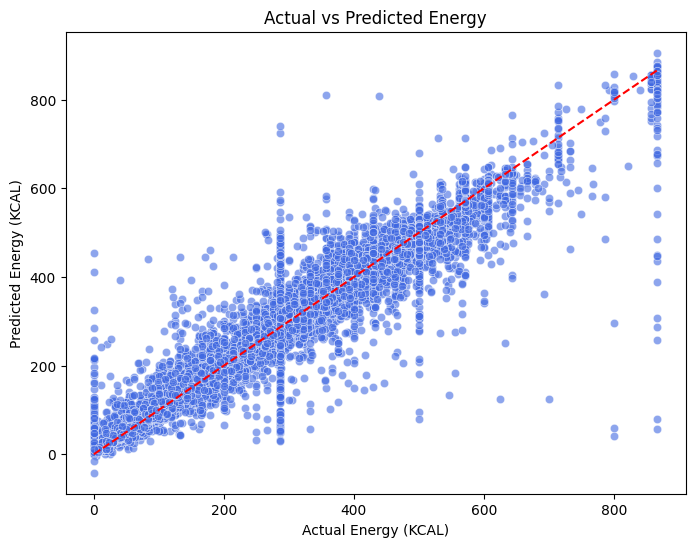

In [18]:
# Plot Actual vs Predicted values
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Energy (KCAL)")
plt.ylabel("Predicted Energy (KCAL)")
plt.title("Actual vs Predicted Energy")
plt.show()


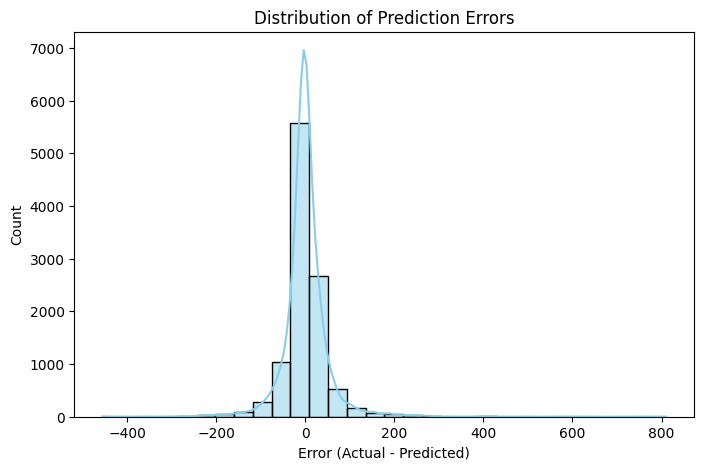

In [19]:
# Plot distribution of prediction errors
errors = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.show()
